# Causal Inference in Buying Groups

In [17]:
# ============================================
# Buying Group Causal Inference Simulation
# Treatment: Bundled purchase incentive (Refrigerant + Cylinder) offered to member
# Outcome: Supplier revenue from that member (in the period)
# Methods: Naïve diff, Propensity Score (logit), IPTW (ATE), Balance (SMD), NN Matching (ATT)
# ============================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from scipy import stats

In [2]:
# -----------------------------
# Reproducibility
# -----------------------------
np.random.seed(42)

# -----------------------------
# Simulate members, suppliers, and confounders
# -----------------------------
n = 3000                                                                  # number of member-supplier "accounts" (observations)
member_size = np.random.lognormal(mean=2.0, sigma=0.5, size=n)            # larger members buy more
hist_volume  = np.random.lognormal(mean=2.2, sigma=0.6, size=n)           # recent purchase volume
supplier_price_idx = np.random.normal(loc=1.0, scale=0.08, size=n)        # price level (higher = pricier)
portfolio_overlap = np.clip(np.random.beta(a=2.0, b=2.0, size=n), 0, 1)   # overlap in SKUs (0-1)
relationship_score = np.random.normal(loc=0.0, scale=1.0, size=n)         # relationship strength

# Optional product connectivity proxy (e.g., same supplier sells both items frequently in market)
# Higher = market commonly buys refrigerant+cylinder bundles (external factor)
market_bundle_intensity = np.clip(np.random.beta(3, 2, n), 0, 1)

# Assemble DataFrame
df = pd.DataFrame({
    "member_size": member_size,
    "hist_volume": hist_volume,
    "supplier_price_idx": supplier_price_idx,
    "portfolio_overlap": portfolio_overlap,
    "relationship_score": relationship_score,
    "market_bundle_intensity": market_bundle_intensity
})

df

,member_size,hist_volume,supplier_price_idx,portfolio_overlap,relationship_score,market_bundle_intensity
0,9.472161,2.872881,0.910873,0.451929,-2.615469,0.338134
1,6.895492,5.385817,0.949526,0.719163,-0.134694,0.594574
2,10.214868,7.041609,0.924635,0.365554,0.061168,0.605873
3,15.823797,28.011429,0.956160,0.036610,-0.534868,0.676409
4,6.572691,12.602962,0.982868,0.249075,-0.089718,0.849041
...,...,...,...,...,...,...
2995,7.680927,10.002965,1.008130,0.881664,-0.883744,0.946703
2996,8.405416,18.021921,1.093377,0.319458,-0.410077,0.402642
2997,3.971404,4.347312,1.127076,0.353306,0.540006,0.307342
2998,8.732819,11.950466,0.945201,0.616891,-0.295110,0.791668


In [3]:
# -----------------------------
#  Treatment assignment mechanism (propensity to offer bundled incentive)
#  Members with larger size, higher historical volume, better relationship, and higher portfolio overlap
#  are more likely to be targeted/exposed. Pricier suppliers are less likely.
# -----------------------------
# Build latent log-odds for treatment (T=1 if incentive is offered)
logit_T = (
    0.40 * (stats.zscore(df["member_size"])) +
    0.45 * (stats.zscore(df["hist_volume"])) +
    0.35 * (stats.zscore(df["portfolio_overlap"])) +
    0.25 * (stats.zscore(df["relationship_score"])) +
    0.30 * (stats.zscore(df["market_bundle_intensity"])) -
    0.40 * (stats.zscore(df["supplier_price_idx"])) +
    np.random.normal(0, 0.5, n)                      # idiosyncratic noise in targeting
)

ps_true = 1 / (1 + np.exp(-logit_T))                 # true propensity (unknown in practice)
T = np.random.binomial(1, ps_true, size=n)           # treatment indicator

df["T"] = T
df["ps_true"] = ps_true

df

,member_size,hist_volume,supplier_price_idx,portfolio_overlap,relationship_score,market_bundle_intensity,T,ps_true
0,9.472161,2.872881,0.910873,0.451929,-2.615469,0.338134,0,0.168366
1,6.895492,5.385817,0.949526,0.719163,-0.134694,0.594574,0,0.302801
2,10.214868,7.041609,0.924635,0.365554,0.061168,0.605873,0,0.592676
3,15.823797,28.011429,0.956160,0.036610,-0.534868,0.676409,0,0.739417
4,6.572691,12.602962,0.982868,0.249075,-0.089718,0.849041,0,0.408103
...,...,...,...,...,...,...,...,...
2995,7.680927,10.002965,1.008130,0.881664,-0.883744,0.946703,1,0.558171
2996,8.405416,18.021921,1.093377,0.319458,-0.410077,0.402642,1,0.667079
2997,3.971404,4.347312,1.127076,0.353306,0.540006,0.307342,0,0.065082
2998,8.732819,11.950466,0.945201,0.616891,-0.295110,0.791668,1,0.724254


In [4]:
# -----------------------------
#  Outcome model (true DGP)
#  Revenue depends on confounders + true treatment effect + noise
# -----------------------------
tau = 12.0   # true causal lift: bundled incentive increases revenue by $12 on average

# Baseline revenue influenced by size, volume, prices, overlap, relationship, market intensity
baseline = (
    15.0
    + 3.8  * stats.zscore(df["member_size"])
    + 4.2  * stats.zscore(df["hist_volume"])
    - 2.5  * stats.zscore(df["supplier_price_idx"])   # higher price → somewhat lower volume/revenue
    + 2.0  * stats.zscore(df["portfolio_overlap"])
    + 1.8  * stats.zscore(df["relationship_score"])
    + 1.5  * stats.zscore(df["market_bundle_intensity"])
)

# Realized revenue
y = baseline + tau * df["T"] + np.random.normal(0, 5.0, n)

df["y"] = y

df.head()

,member_size,hist_volume,supplier_price_idx,portfolio_overlap,relationship_score,market_bundle_intensity,T,ps_true,y
0,9.472161,2.872881,0.910873,0.451929,-2.615469,0.338134,0,0.168366,-0.412343
1,6.895492,5.385817,0.949526,0.719163,-0.134694,0.594574,0,0.302801,13.296174
2,10.214868,7.041609,0.924635,0.365554,0.061168,0.605873,0,0.592676,12.663876
3,15.823797,28.011429,0.956160,0.036610,-0.534868,0.676409,0,0.739417,24.747512
4,6.572691,12.602962,0.982868,0.249075,-0.089718,0.849041,0,0.408103,20.029377


In [11]:
# -----------------------------
# Naïve difference in means (biased if confounded)
# -----------------------------
naive_diff = df.loc[df["T"] == 1, "y"].mean() - df.loc[df["T"] == 0, "y"].mean()
print("== Naïve Comparison (Unadjusted) ==")
print(f"Mean(y | T=1) - Mean(y | T=0) = {naive_diff:,.2f}")

#Note: This mixes causal effect with confounding (targeting of larger/richer/overlap members)

== Naïve Comparison (Unadjusted) ==
Mean(y | T=1) - Mean(y | T=0) = 16.46


In [6]:
# -----------------------------
# Propensity Score via Logistic Regression (on observed confounders)
# -----------------------------
X = df[["member_size", "hist_volume", "supplier_price_idx",
        "portfolio_overlap", "relationship_score", "market_bundle_intensity"]].copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

logit = LogisticRegression(max_iter=400, solver="lbfgs")
logit.fit(X_scaled, df["T"])
ps_hat = logit.predict_proba(X_scaled)[:, 1]

# clip to avoid extreme weights
df["ps"] = np.clip(ps_hat, 1e-3, 1 - 1e-3)

df.head()

,member_size,hist_volume,supplier_price_idx,portfolio_overlap,relationship_score,market_bundle_intensity,T,ps_true,y,ps
0,9.472161,2.872881,0.910873,0.451929,-2.615469,0.338134,0,0.168366,-0.412343,0.233295
1,6.895492,5.385817,0.949526,0.719163,-0.134694,0.594574,0,0.302801,13.296174,0.524213
2,10.214868,7.041609,0.924635,0.365554,0.061168,0.605873,0,0.592676,12.663876,0.523469
3,15.823797,28.011429,0.956160,0.036610,-0.534868,0.676409,0,0.739417,24.747512,0.765349
4,6.572691,12.602962,0.982868,0.249075,-0.089718,0.849041,0,0.408103,20.029377,0.533806


In [12]:
# -----------------------------
# IPTW for ATE
# -----------------------------
w = np.where(df["T"] == 1, 1/df["ps"], 1/(1 - df["ps"]))
df["w"] = w

m1 = df["T"] == 1
m0 = ~m1

y1_hat = np.average(df.loc[m1, "y"].to_numpy(), weights=df.loc[m1, "w"].to_numpy())
y0_hat = np.average(df.loc[m0, "y"].to_numpy(), weights=df.loc[m0, "w"].to_numpy())
ate_iptw = y1_hat - y0_hat

print("== IPTW (Propensity-Weighted) ATE ==")
print(f"Weighted Mean(y|T=1) - Weighted Mean(y|T=0) = {ate_iptw:,.2f}")

#Interpretation: Should be close to the true causal lift (tau ≈ 12) if confounding is well-adjusted.

== IPTW (Propensity-Weighted) ATE ==
Weighted Mean(y|T=1) - Weighted Mean(y|T=0) = 12.01


In [15]:
# -----------------------------
# Covariate Balance: Standardized Mean Differences (before vs after weighting)
# -----------------------------
def smd(x_t, x_c):
    # Standardized mean difference: (mean_t - mean_c) / pooled SD
    mt, mc = x_t.mean(), x_c.mean()
    st, sc = x_t.std(ddof=1), x_c.std(ddof=1)
    sp = np.sqrt((st**2 + sc**2) / 2.0)
    return (mt - mc) / sp

def smd_weighted(x, t, w):
    # Weighted SMD using group-wise weighted means and variances
    x = np.asarray(x).ravel()
    t = np.asarray(t).ravel()
    w = np.asarray(w).ravel()
    m1 = (t == 1)
    m0 = ~m1
    xt, xc = x[m1], x[m0]
    wt, wc = w[m1], w[m0]

    mt = np.average(xt, weights=wt)
    mc = np.average(xc, weights=wc)

    def wvar(vals, weights, mean):
        wn = weights / weights.sum()
        return np.sum(wn * (vals - mean)**2)

    vt = wvar(xt, wt, mt)
    vc = wvar(xc, wc, mc)
    sp = np.sqrt((vt + vc) / 2.0)
    return (mt - mc) / sp

covs = ["member_size", "hist_volume", "supplier_price_idx",
        "portfolio_overlap", "relationship_score", "market_bundle_intensity"]

print("== Covariate Balance (Standardized Mean Differences) ==\n")
print("Variable                  SMD (Unweighted)     SMD (Weighted)")
t_arr = df["T"].to_numpy()
w_arr = df["w"].to_numpy()

for c in covs:
    x_t = df.loc[df["T"] == 1, c].to_numpy()
    x_c = df.loc[df["T"] == 0, c].to_numpy()
    s_unw = smd(x_t, x_c)
    s_w   = smd_weighted(df[c].to_numpy(), t_arr, w_arr)
    print(f"{c:25s} {s_unw:12.3f}            {s_w:12.3f}")
    
print("\nRule of thumb: |SMD| < 0.1 indicates good balance.\n")

== Covariate Balance (Standardized Mean Differences) ==

Variable                  SMD (Unweighted)     SMD (Weighted)
member_size                      0.260                  -0.020
hist_volume                      0.367                   0.022
supplier_price_idx              -0.318                  -0.012
portfolio_overlap                0.295                   0.005
relationship_score               0.224                   0.013
market_bundle_intensity          0.304                   0.008

Rule of thumb: |SMD| < 0.1 indicates good balance.



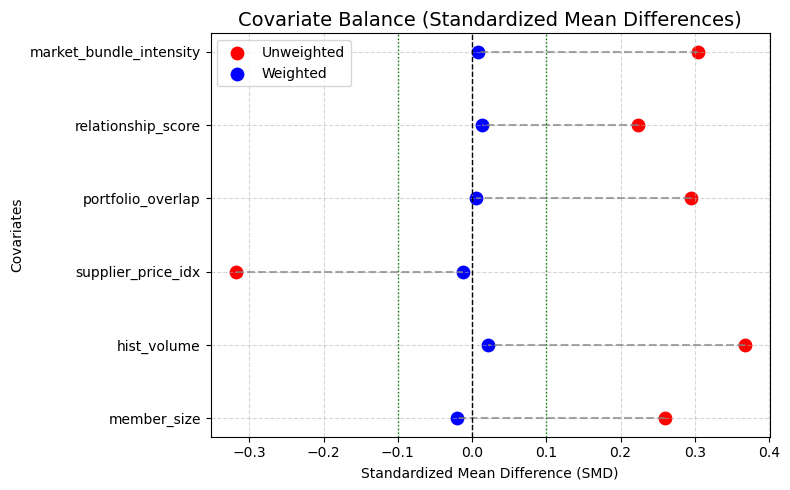

In [19]:
# =============================
# Covariate Balance Plot (SMDs)
# =============================

covariates = [
    "member_size",
    "hist_volume",
    "supplier_price_idx",
    "portfolio_overlap",
    "relationship_score",
    "market_bundle_intensity"
]

# New SMD values from results
smd_unweighted = np.array([0.260, 0.367, -0.318, 0.295, 0.224, 0.304])
smd_weighted   = np.array([-0.020, 0.022, -0.012, 0.005, 0.013, 0.008])

# Plot
plt.figure(figsize=(8,5))

# Plot unweighted and weighted points
plt.scatter(smd_unweighted, covariates, color="red", label="Unweighted", s=80)
plt.scatter(smd_weighted, covariates, color="blue", label="Weighted", s=80)

# Add horizontal lines connecting unweighted → weighted for each covariate
for i, cov in enumerate(covariates):
    plt.plot([smd_unweighted[i], smd_weighted[i]], [cov, cov],
             color="gray", linestyle="--", alpha=0.7)

# Reference lines for thresholds
plt.axvline(x=0, color="black", linestyle="--", linewidth=1)
plt.axvline(x=0.1, color="green", linestyle=":", linewidth=1)
plt.axvline(x=-0.1, color="green", linestyle=":", linewidth=1)

plt.title("Covariate Balance (Standardized Mean Differences)", fontsize=14)
plt.xlabel("Standardized Mean Difference (SMD)")
plt.ylabel("Covariates")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()

# Save and show
plt.savefig('images/chp4_smd_bundle.png', dpi=300)
plt.show()

In [20]:
# -----------------------------
# Nearest-Neighbor Matching for ATT (match on propensity score)
# -----------------------------
treated = df.loc[df["T"] == 1].copy()
control = df.loc[df["T"] == 0].copy()

# Ensure no missing/inf PS
treated = treated[np.isfinite(treated["ps"])]
control = control[np.isfinite(control["ps"])]

nbrs = NearestNeighbors(n_neighbors=1, algorithm="auto")
nbrs.fit(control[["ps"]].to_numpy())

dist, idx = nbrs.kneighbors(treated[["ps"]].to_numpy())
matched_controls = control.iloc[idx.flatten()].reset_index(drop=True)

att_nn = (treated["y"].reset_index(drop=True) - matched_controls["y"]).mean()

print("== Nearest-Neighbor Matching (ATT) ==")
print(f"ATT (matched on propensity score) = {att_nn:,.2f}")

# Interpretation: Effect for those exposed to the bundle; expect close to tau if matching is good

== Nearest-Neighbor Matching (ATT) ==
ATT (matched on propensity score) = 12.15


In [24]:
# -----------------------------
# Summary
# -----------------------------
print("== Summary ==")
print(f"True effect (tau):                 {tau:,.2f}   (created by simulation)")
print(f"Naïve diff in means:               {naive_diff:,.2f}   (biased by targeting/confounding)")
print(f"IPTW ATE (propensity-weighted):    {ate_iptw:,.2f}   (aims at causal ATE)")
print(f"ATT via NN matching:               {att_nn:,.2f}   (effect on treated)")

== Summary ==
True effect (tau):                 12.00   (created by simulation)
Naïve diff in means:               16.46   (biased by targeting/confounding)
IPTW ATE (propensity-weighted):    12.01   (aims at causal ATE)
ATT via NN matching:               12.15   (effect on treated)


\Summary of Results.}  
In this simulation, the true causal effect of the bundled incentive was set to 
\$\tau = 12.00$, meaning that adopting the bundle increases member revenue by about 
\$12 on average. A naïve comparison of means produced a larger effect 
(\$16.46), but this estimate is biased because larger, richer members with greater 
portfolio overlap were more likely to receive the incentive. In other words, the 
naïve gap reflects both the causal effect \emph{and} the pre-existing advantages 
of targeted members.  

After applying Inverse Probability of Treatment Weighting (IPTW), the treated and 
control groups became balanced on observed covariates, yielding an estimate of 
\$12.01, almost identical to the true causal effect. Nearest-Neighbor Matching, 
which pairs each treated member with a comparable untreated member, produced a 
similar estimate of \$12.15.  

\noindent\textbf{Conclusion:} Both IPTW (for the Average Treatment Effect) and 
Matching (for the Average Treatment Effect on the Treated) recover the true 
causal lift of the bundle, while the naïve comparison is inflated by confounding. 
These results illustrate how causal inference tools help distinguish real effects 
from spurious correlations in observational data.
